<a href="https://colab.research.google.com/github/Geethen/Invasive_Species_Mapping/blob/main/example_usuage/end_to_end_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook demonstrates the 8 steps to create and export an invasive tree species image
> #### Input: Reference points (GEE FeatureCollection) containing the classes of interest as a property.
> #### Arguments: A start and end data, cloud threshold, area of interest, image composite interval
> #### Output: Invasive Tree species map

**Step 1**: Install and load modules  
**Step 2**: Prepare time series composite and additional covariates  
**Step 3**: Prepare dataset for model training and evaluation  
**Step 4**: Export data (optional)  
**Step 5**: Fit model  
**Step 6**: Model evaluation  
**Step 7**: Visualize classified image  
**Step 8**: Export classified image  

## Step 1: Install and load modules

In [1]:
%pip install watermark geemap geeml -q
!git clone https://github.com/Geethen/Invasive_Species_Mapping.git
import sys
sys.path.insert(0,'/content/Invasive_Species_Mapping/code')

Note: you may need to restart the kernel to use updated packages.


fatal: destination path 'Invasive_Species_Mapping' already exists and is not an empty directory.


In [2]:
%load_ext watermark

In [1]:
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import geemap

# Add module to environment varibles
import sys
MODULE_FULL_PATH = r'C:\Users\coach\myfiles\postdoc\code\Invasive_Species_Mapping\code'
sys.path.insert(1, MODULE_FULL_PATH)

# Load python modules with preprocessing functions. 
from timeSeriesFunctions import prepareTS
from covariateFunctions import prepareCovariates
from trainDataFunctions import prepareTrainingData
from modelFitFunctions import prepareModel
from metricFunctions import prepareMetrics
from geeml.utils import eeprint

In [3]:
%watermark -v -m --iversions

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

ee    : 0.2
sys   : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC v.1929 64 bit (AMD64)]
geemap: 0.17.1



In [4]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Step 2: Prepare time series composite

### Prepare Sentinel-2 Data

In [5]:
# start and end dates for time series
Date_Start = ee.Date('2017-01-01')
Date_End = ee.Date('2017-12-31')

# how many days to summarise in each image e.g 30 days = 12 images per year
day_int = 30 #step size

# cloud probabillity threshold
CLOUD_THRESH=30

# which bands to keep
BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6','B7', 'B8', 'B8A', 'B9', 'B11','B12', 'ndvi','ndwi','ndre','nbr','evi']

aoi = ee.Geometry.Point([25.181, -28.490])
# define your study area
study_area1 = ee.Geometry.Polygon([[[30.555572509765607, -24.407014032416797],
          [31.065750122070295, -24.40888986482876],
          [31.065750122070295, -24.40888986482876],
          [31.049957275390607, -25.121539326337704],
          [30.560379028320295, -25.133972597740186],
          [30.555572509765607, -24.407014032416797]]], None, False)

# flatten imagecollection to image - each image becomes a band
s2TS = prepareTS(Date_Start,Date_End,day_int,study_area1,CLOUD_THRESH,BANDS)\
.timeSeries(satellite = 'S2', s2_level = 1)

# Add additional terrain related covariates
X = prepareCovariates(proj = 'EPSG:32726', covariates = s2TS, nAngles = 10).addCovariates(rotatedCoords = True, topoBands =True)
X.bandNames()

In [6]:
Map.addLayer(study_area1)
Map.centerObject(study_area1, 8)

## Step 3: Prepare dataset for model training and evaluation

### Add additional covariates and extract covariates to points.

In this notebook, the reference points (shapefile) is already uploaded to Google Earth Engine (GEE). However, if you need to upload your shapefile to GEE you could either [manually upload it](https://developers.google.com/earth-engine/guides/table_upload) or you could upload it by using the geeup package. An example can be found [here](https://github.com/Geethen/Invasive_Species_Mapping/blob/main/example_usuage/geeup_Simple_CLI_for_Earth_Engine_Uploads.ipynb).

#### Load training data

In [6]:
# Import reference points
points = ee.FeatureCollection("users/moilwekk/merged_classes")

# name of the label property
label = 'code'

# number of folds for kfold
FOLDS = 10       

# Extract covariate image values to points
pTrainData = prepareTrainingData(covariates = X, points = points, targetProperty = label, nFolds = FOLDS, proj =  'EPSG:32726')
train = pTrainData.covariatesToPoints()
# train.limit(2)

## Step 4: Export data (Optional)

### Export (to GEE asset) training data and image to run inference on

In [ ]:
# export training data and image to classify
# Define the export parameters
export_params1 = {
    'collection': train,
    'description': 'export_trainData',
    'assetId': 'users/geethensingh/trainData'
}

export_params2 = {
    'image': X,
    'description': 'export_inferenceImage',
    'assetId': 'users/geethensingh/inferenceImage',
    'scale': 10,
    'region': study_area1
}

# Export the data to the Earth Engine asset
ee.batch.Export.table.toAsset(**export_params1).start()
ee.batch.Export.image.toAsset(**export_params2).start()

## Step 5: Fit model

### Fit a random forest model using Kfold cross validation. Each fold is one spatial cluster (clustering on x and y coordinates)

In [7]:
# load DATA (if exported earlier)
# train = ee.FeatureCollection('users/geethensingh/trainData')
# X = ee.Image('users/geethensingh/inferenceImage')

bandnames = X.bandNames()
# number of classes
NCLASS = train.aggregate_histogram(label).size()

In [8]:
%load_ext autoreload

%autoreload 2
# fit k-fold classifiers
# apply function and train kfold classifieres
test = prepareModel(dataset = train, responseCol = label, inferenceImage = X, bandNames = bandnames)

In [16]:
from geedim.download import BaseImage
file = r'D:\inference.tif'
BaseImage(test.inferenceImage).download(file, crs= 'EPSG:4326', region = study_area1,
                                                 scale = 10, overwrite=True, num_threads=20)

Consider adjusting `region`, `scale` and/or `dtype` to reduce the inference.tif download size (raw: 86.43 GB).


inference.tif: |          | 0.00/86.4G (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


In [9]:
%autoreload 2
model = test.calibratedClassifier

In [11]:
from mapie.classification import MapieClassifier

# Initialize the Conformal Prediction classifier
X_cal, y_cal = test.calibrationData
rf = test.fittedClassifier
confPredictor = MapieClassifier(estimator=rf, cv="prefit", method="raps")
confPredictor.fit(X_cal, y_cal)

MapieClassifier(cv='prefit',
                estimator=RandomForestClassifier(max_features=20,
                                                 n_estimators=50, n_jobs=-1,
                                                 random_state=0),
                method='raps')

In [12]:
import rasterio
import pandas as pd
import rasterio
from rasterio.plot import reshape_as_image
import numpy as np

# Specify the path to your TIFF file
tif_file = r'D:\inference.tif'

# Define the subset window (in pixel coordinates)
# The window is defined as (row_start, row_stop), (col_start, col_stop)
subset_window = ((0, 32), (0, 32))

# Open the TIFF file
with rasterio.open(tif_file) as src:
    # Read the subset of the raster data using the defined window
    src_array = src.read(window=subset_window)
    # print(src.crs)

    # format into pandas df
    # src_array = src.read(window=window)
    i_arr = reshape_as_image(src_array)

    # Save the window image as a new TIFF file
    output_tif_file = r'C:\Users\coach\myfiles\postdoc\Uncertainty\scratch\window_image.tif'
    with rasterio.open(output_tif_file, 'w', driver='GTiff', width=i_arr.shape[1], height=i_arr.shape[0],
                    count=i_arr.shape[2], dtype=i_arr.dtype, crs = src.crs) as dst:
        dst.write(src_array)

    print("Window image has been saved as:", output_tif_file)

    #Format input_image for inference
    nPixels = i_arr.shape[0]*i_arr.shape[1]
    nBands = i_arr.shape[-1]
    # Take full image and reshape into long 2d array (nrow * ncol, nband) for classification
    new_arr = i_arr.reshape(nPixels, nBands)#reshape 3d array to 2d array that matches the training data table from earlier
    bandnames = list(src.descriptions)
    data = pd.DataFrame(new_arr, columns = bandnames).fillna(0)
    mapie_prob_preds = model.predict_proba(data)
    mapie_prob_preds = mapie_prob_preds[~np.isnan(mapie_prob_preds)]
    y_pred_score, y_ps_score = confPredictor.predict(data, alpha = 0.1)
    # # Reshape our classification map back into a 2D matrix so we can save it as an image
    labels = y_pred_score.reshape(i_arr[:, :, 0].shape).astype(np.float64)
    probs = mapie_prob_preds.reshape(i_arr[:, :, 0].shape).astype(np.float64)
    sets = y_ps_score.reshape([i_arr.shape[0],i_arr.shape[1], rf.n_classes_]).astype(np.float64)


RasterioIOError: D:/inference.tif: No such file or directory

In [17]:
infile = r'C:\Users\coach\myfiles\postdoc\Uncertainty\scratch\window_image.tif'
outfile = r'C:\Users\coach\myfiles\postdoc\Uncertainty\scratch\pred_window_labels.tif'
%autoreload 2

test.inference(mode = 'predict', infile = infile, model = model, confModel= confPredictor, outfile = outfile, patchSize = 16, num_workers = 10)

pred_window_labels.tif:   0%|          | 0/4 [00:00<?, ?it/s]

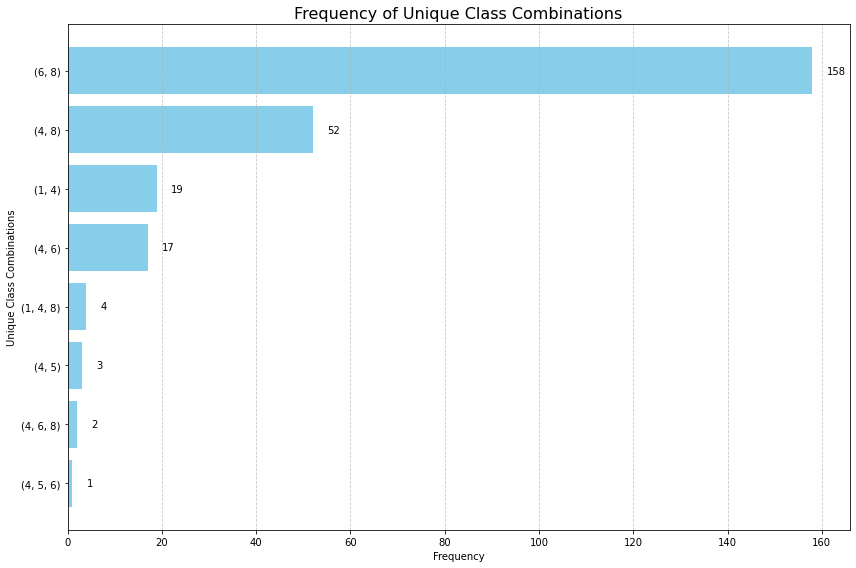

In [138]:
unique_class_combinations = []  # List to store unique class combinations
combination_frequencies = {}  # Dictionary to store combination frequencies

for i in range(result_.shape[0]):
    classes = model.classes_
    mask = y_ps_score[i, :, 0]
    inverted_mask = ~mask
    class_combination = tuple(classes[mask].tolist())

    if class_combination not in unique_class_combinations:
        unique_class_combinations.append(class_combination)
    combination_frequencies[class_combination] = combination_frequencies.get(class_combination, 0) + 1

# Sort unique_class_combinations and frequencies in descending order of frequencies
sorted_indices = np.argsort(frequencies)[::-1]
sorted_unique_class_combinations = [unique_class_combinations[i] for i in sorted_indices]
sorted_frequencies = [frequencies[i] for i in sorted_indices]

# Plotting the frequency distribution
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(sorted_unique_class_combinations)), sorted_frequencies, color='skyblue')
plt.yticks(range(len(sorted_unique_class_combinations)), [str(combination) for combination in sorted_unique_class_combinations])
plt.xlabel('Frequency')
plt.ylabel('Unique Class Combinations')
plt.title('Frequency of Unique Class Combinations', fontsize=16)
plt.gca().invert_yaxis()  # Invert the y-axis to show the combinations from top to bottom
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add the frequency count on top of each bar
for bar, frequency in zip(bars, sorted_frequencies):
    plt.text(bar.get_width() +3 , bar.get_y() + bar.get_height() / 2, str(frequency), ha='left', va='center')

plt.tight_layout()
plt.show()

In [125]:
import numpy as np
for i in range(0,result_.shape[0]):
    classes = model.classes_
    mask = y_ps_score[i,:, 0]
    mx = np.ma.masked_array(classes, mask= ~mask, fill_value = 0)
    remaining_length = np.count_nonzero(~mx.mask)
    print(mx)
    print(remaining_length)

[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[1 -- -- 4 -- -- -- -- --]
2
[1 -- -- 4 -- -- -- -- --]
2
[-- -- -- 4 5 -- -- -- --]
2
[-- -- -- 4 5 -- -- -- --]
2
[-- -- -- 4 5 -- -- -- --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 5 6 -- -- --]
3
[-- -- -- 4 -- 6 -- -- --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- --

In [ ]:
the distance between the top-2 predicted classes


In [8]:
# fit k-fold classifiers
# apply function and train kfold classifieres
result = prepareModel(dataset = train, responseCol = label, inferenceImage = X, bandNames = bandnames).kFoldCV(10)
result

## Step 6: Model evaluation

### Compute average accuracy and summed confusion matrix for all folds

In [9]:
modeClassImage = prepareMetrics(classImage = result, nClasses = NCLASS, nFolds = FOLDS).confusionMatrix()
modeClassImage

The average weighted accuracy is [0.7054208273894437] across 10 folds


## Step 7: Visualise clasiified Image

In [ ]:
legend_dict = {
    "Wattle": "00FF00",
    "Bracken": "008000",
    "Eucalyptus": "808080",
    "Forest": "800080",
    "Grassland": "FF00FF",
    "Mixed Woody Grassland": "00FFFF",
    "None Vegetated Features": "FFFF00",
    "Pines": "000080",
    "Recently Cleared Plantations/Young Pines": "800000"
}

palette = ['00FF00',# Wattle-Lime
          '008000', #Bracken-Green
          '808080', #Eucalyptus-Grey
          '800080', #Forest-Purple
          'FF00FF', #Grassland-Pink
          '00FFFF', #Mixed Woody Grassland-Aqua
          'FFFF00', #None Vegetated Features-Yellow
          '000080', #Pines-Navy
          '800000'] #(Recently Cleared Plantations/Young Pines)-Maroon (DarkBrown)

vis_params = {
    'min': 0,
    'max': 8,
    'palette': palette,
}

Map = geemap.Map()
Map.centerObject(study_area1, 8)
Map.addLayer(modeClassImage, vis_params, 'Classified Image')
Map.add_legend(legend_dict = legend_dict)
Map

Map(center=[-24.76509915990505, 30.807101743053455], controls=(WidgetControl(options=['position', 'transparent…

## Step 8: Export classified image (optional)

In [ ]:
# export results
export_params3 = {
    'image': modeClassImage,
    'description': 'export_classImage',
    'assetId': 'users/geethensingh/classImage',
    'scale': 10,
    'region': study_area1
}

# Export the data to the Earth Engine asset
ee.batch.Export.image.toAsset(**export_params3).start()